# Laboratory exercise 3

## Imports

In [1]:
import os
import glob
import re
import string

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
from nltk import word_tokenize
from nltk.corpus import stopwords
from scripts.word_embeddings import load_embedding_weights
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Input, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

from scripts.nlg_evaluation import score_predictions

## Load data

In [2]:
BASE_PATH = 'data/OpinosisDataset1.0_0/'

In [3]:
topic_file_paths = glob.glob(BASE_PATH + 'topics/*.txt.data')
topic_file_paths[:5]

['data/OpinosisDataset1.0_0/topics\\accuracy_garmin_nuvi_255W_gps.txt.data',
 'data/OpinosisDataset1.0_0/topics\\bathroom_bestwestern_hotel_sfo.txt.data',
 'data/OpinosisDataset1.0_0/topics\\battery-life_amazon_kindle.txt.data',
 'data/OpinosisDataset1.0_0/topics\\battery-life_ipod_nano_8gb.txt.data',
 'data/OpinosisDataset1.0_0/topics\\battery-life_netbook_1005ha.txt.data']

In [4]:
summaries_file_paths = glob.glob(BASE_PATH + 'summaries-gold/*/*.gold')
summaries_file_paths[:5]

['data/OpinosisDataset1.0_0/summaries-gold\\accuracy_garmin_nuvi_255W_gps\\accuracy_garmin_nuvi_255W_gps.1.gold',
 'data/OpinosisDataset1.0_0/summaries-gold\\accuracy_garmin_nuvi_255W_gps\\accuracy_garmin_nuvi_255W_gps.2.gold',
 'data/OpinosisDataset1.0_0/summaries-gold\\accuracy_garmin_nuvi_255W_gps\\accuracy_garmin_nuvi_255W_gps.3.gold',
 'data/OpinosisDataset1.0_0/summaries-gold\\accuracy_garmin_nuvi_255W_gps\\accuracy_garmin_nuvi_255W_gps.4.gold',
 'data/OpinosisDataset1.0_0/summaries-gold\\accuracy_garmin_nuvi_255W_gps\\accuracy_garmin_nuvi_255W_gps.5.gold']

In [5]:
data = []
for topic_file_path in topic_file_paths:
    with open(topic_file_path, 'r') as f:
        base_name = os.path.basename(f.name)
        topic_name = re.match(r'(.*)\.txt\.data', base_name).group(1)
        topic_text = f.read()
        data.append(
            {
                'topic_name': topic_name,
                'topic_text': topic_text
            }
        )
df_topic = pd.DataFrame(data)
df_topic.head(5)

,topic_name,topic_text
0,accuracy_garmin_nuvi_255W_gps,", and is very, very accurate .\n but for the m..."
1,bathroom_bestwestern_hotel_sfo,"The room was not overly big, but clean and ve..."
2,battery-life_amazon_kindle,After I plugged it in to my USB hub on my com...
3,battery-life_ipod_nano_8gb,short battery life I moved up from an 8gb .\...
4,battery-life_netbook_1005ha,"6GHz 533FSB cpu, glossy display, 3, Cell 23Wh ..."


In [6]:
data = []
for summary_file_path in summaries_file_paths:
    with open(summary_file_path, 'r') as f:
        base_name = os.path.basename(f.name)
        topic_name = re.match(r'(.*)\.\d\.gold', base_name).group(1)
        summary_text = f.read()
        data.append(
            {
                'topic_name': topic_name,
                'summary_text': summary_text
            }
        )
df_summary = pd.DataFrame(data)
df_summary.head(5)

,topic_name,summary_text
0,accuracy_garmin_nuvi_255W_gps,This unit is generally quite accurate. \nSet-...
1,accuracy_garmin_nuvi_255W_gps,The Garmin seems to be generally very accurate...
2,accuracy_garmin_nuvi_255W_gps,"It is very accurate, even in destination time.\n"
3,accuracy_garmin_nuvi_255W_gps,Very accurate with travel and destination time...
4,accuracy_garmin_nuvi_255W_gps,"Its accurate, fast and its simple operations m..."


In [7]:
df_raw = df_topic.merge(df_summary, on='topic_name')
df_raw

,topic_name,topic_text,summary_text
0,accuracy_garmin_nuvi_255W_gps,", and is very, very accurate .\n but for the m...",This unit is generally quite accurate. \nSet-...
1,accuracy_garmin_nuvi_255W_gps,", and is very, very accurate .\n but for the m...",The Garmin seems to be generally very accurate...
2,accuracy_garmin_nuvi_255W_gps,", and is very, very accurate .\n but for the m...","It is very accurate, even in destination time.\n"
3,accuracy_garmin_nuvi_255W_gps,", and is very, very accurate .\n but for the m...",Very accurate with travel and destination time...
4,accuracy_garmin_nuvi_255W_gps,", and is very, very accurate .\n but for the m...","Its accurate, fast and its simple operations m..."
...,...,...,...
233,voice_garmin_nuvi_255W_gps,The voice prompts and maps are wonderful esp...,The voice is a bit robotic.\nThe voice is very...
234,voice_garmin_nuvi_255W_gps,The voice prompts and maps are wonderful esp...,The voices sound robotic.\nTTS mode is the mos...
235,voice_garmin_nuvi_255W_gps,The voice prompts and maps are wonderful esp...,255W garmin gps has more than 750 voices but t...
236,voice_garmin_nuvi_255W_gps,The voice prompts and maps are wonderful esp...,Voice is clear and sweet.\nVoice commands are ...


## Preprocessing

In [8]:
df_raw['topic_tokenized'] = df_raw['topic_text'].apply(lambda x: word_tokenize(x.lower()))
df_raw['summary_tokenized'] = df_raw['summary_text'].apply(lambda x: word_tokenize(x.lower()))
df_raw

,topic_name,topic_text,summary_text,topic_tokenized,summary_tokenized
0,accuracy_garmin_nuvi_255W_gps,", and is very, very accurate .\n but for the m...",This unit is generally quite accurate. \nSet-...,"[,, and, is, very, ,, very, accurate, ., but, ...","[this, unit, is, generally, quite, accurate, ...."
1,accuracy_garmin_nuvi_255W_gps,", and is very, very accurate .\n but for the m...",The Garmin seems to be generally very accurate...,"[,, and, is, very, ,, very, accurate, ., but, ...","[the, garmin, seems, to, be, generally, very, ..."
2,accuracy_garmin_nuvi_255W_gps,", and is very, very accurate .\n but for the m...","It is very accurate, even in destination time.\n","[,, and, is, very, ,, very, accurate, ., but, ...","[it, is, very, accurate, ,, even, in, destinat..."
3,accuracy_garmin_nuvi_255W_gps,", and is very, very accurate .\n but for the m...",Very accurate with travel and destination time...,"[,, and, is, very, ,, very, accurate, ., but, ...","[very, accurate, with, travel, and, destinatio..."
4,accuracy_garmin_nuvi_255W_gps,", and is very, very accurate .\n but for the m...","Its accurate, fast and its simple operations m...","[,, and, is, very, ,, very, accurate, ., but, ...","[its, accurate, ,, fast, and, its, simple, ope..."
...,...,...,...,...,...
233,voice_garmin_nuvi_255W_gps,The voice prompts and maps are wonderful esp...,The voice is a bit robotic.\nThe voice is very...,"[the, voice, prompts, and, maps, are, wonderfu...","[the, voice, is, a, bit, robotic, ., the, voic..."
234,voice_garmin_nuvi_255W_gps,The voice prompts and maps are wonderful esp...,The voices sound robotic.\nTTS mode is the mos...,"[the, voice, prompts, and, maps, are, wonderfu...","[the, voices, sound, robotic, ., tts, mode, is..."
235,voice_garmin_nuvi_255W_gps,The voice prompts and maps are wonderful esp...,255W garmin gps has more than 750 voices but t...,"[the, voice, prompts, and, maps, are, wonderfu...","[255w, garmin, gps, has, more, than, 750, voic..."
236,voice_garmin_nuvi_255W_gps,The voice prompts and maps are wonderful esp...,Voice is clear and sweet.\nVoice commands are ...,"[the, voice, prompts, and, maps, are, wonderfu...","[voice, is, clear, and, sweet, ., voice, comma..."


In [9]:
def filter_stopwords_and_punctuation(tokens_list: pd.Series) -> pd.Series:
    stopset = set(stopwords.words('english'))
    punctuation = set(string.punctuation)
    filter_set = stopset | punctuation

    return tokens_list.apply(
        lambda tokens:
            np.array(list(filter(lambda token: token not in filter_set, tokens)))
    )

In [10]:
df_raw['topic_tokenized_filtered'] = filter_stopwords_and_punctuation(df_raw['topic_tokenized'])
df_raw['summary_tokenized_filtered'] = filter_stopwords_and_punctuation(df_raw['summary_tokenized'])

In [11]:
df_raw['summary_tokenized_filtered'] = df_raw['summary_tokenized_filtered'].apply(lambda x: ['<START>', *x, '<END>'])

In [12]:
df_raw['summary_tokenized_filtered']

0      [<START>, unit, generally, quite, accurate, se...
1      [<START>, garmin, seems, generally, accurate, ...
2      [<START>, accurate, even, destination, time, <...
3      [<START>, accurate, travel, destination, time,...
4      [<START>, accurate, fast, simple, operations, ...
                             ...                        
233    [<START>, voice, bit, robotic, voice, clear, l...
234    [<START>, voices, sound, robotic, tts, mode, p...
235    [<START>, 255w, garmin, gps, 750, voices, soun...
236    [<START>, voice, clear, sweet, voice, commands...
237                 [<START>, voice, clear, loud, <END>]
Name: summary_tokenized_filtered, Length: 238, dtype: object

In [13]:
def get_vocabulary(tokens_list: pd.Series) -> pd.Series:
    return tokens_list.explode().value_counts()

In [14]:
vocabulary = get_vocabulary(df_raw['topic_tokenized_filtered'])
vocabulary

room            4214
great           4185
location        4183
hotel           3409
staff           3400
                ... 
webupdates         3
registration       3
nt                 3
webupdater         3
atlas              3
Name: topic_tokenized_filtered, Length: 7184, dtype: int64

<AxesSubplot:xlabel='topic_tokenized_filtered', ylabel='Count'>

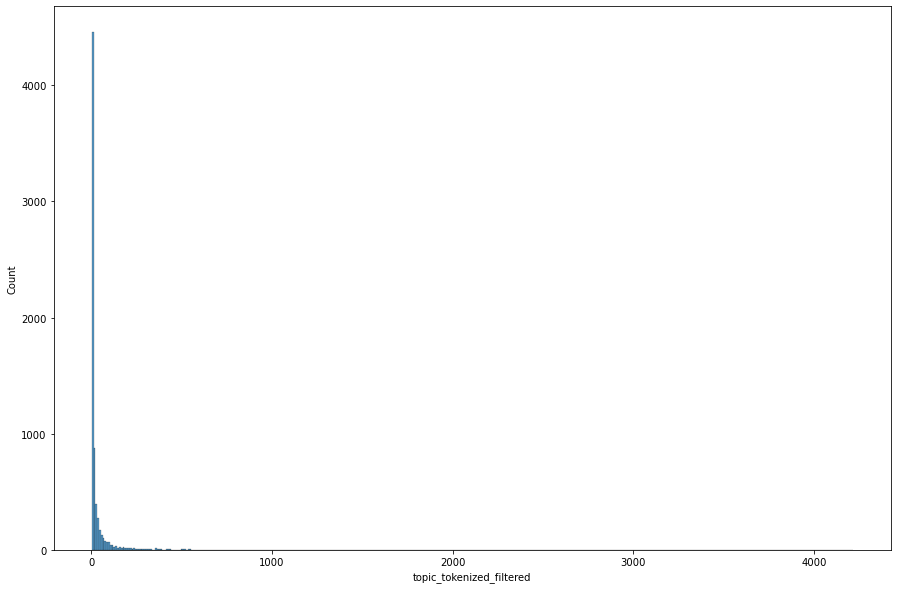

In [15]:
_, ax = plt.subplots(figsize=(15, 10))
sns.histplot(vocabulary, bins=len(vocabulary.unique()))

In [16]:
def vocabulary_with_removed_less_than_k(vocabulary, k):
    return vocabulary[vocabulary > k]

In [17]:
smaller_voc = vocabulary_with_removed_less_than_k(vocabulary, 10)

In [18]:
smaller_voc = smaller_voc.append(pd.Series([0, 0, 0, 0], index=['<START>', '<END>', '<OTHER>', '<PAD>']))
smaller_voc

room        4214
great       4185
location    4183
hotel       3409
staff       3400
            ... 
peak          11
<START>        0
<END>          0
<OTHER>        0
<PAD>          0
Length: 2937, dtype: int64

<AxesSubplot:ylabel='Count'>

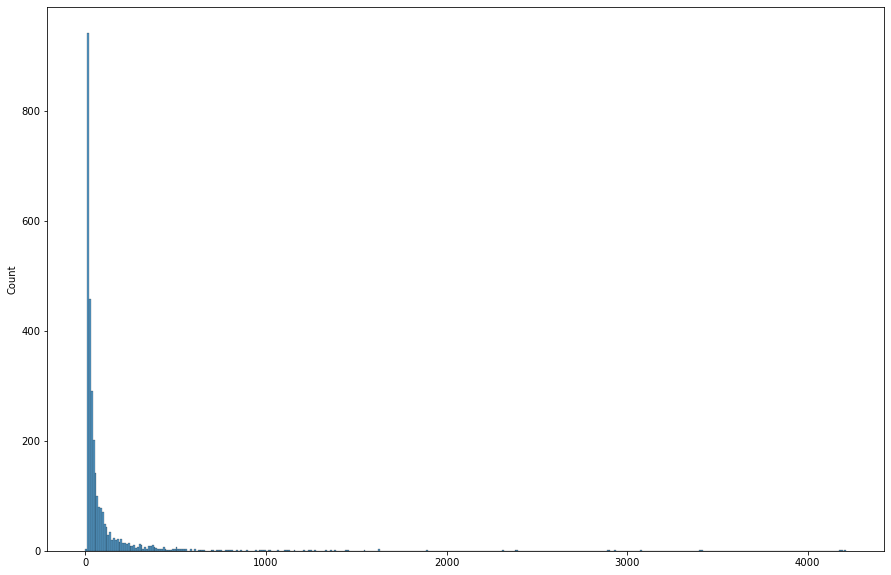

In [19]:
_, ax = plt.subplots(figsize=(15, 10))
sns.histplot(smaller_voc, bins=len(smaller_voc.unique()))

In [20]:
print(f'{len(smaller_voc)=}')

len(smaller_voc)=2937


In [21]:
x_train_val, x_test, y_train_val, y_test = train_test_split(
    df_raw['topic_tokenized_filtered'], df_raw['summary_tokenized_filtered'], test_size=0.2, random_state=42
)

In [22]:
word_to_id = {word: idx for idx, word in enumerate(smaller_voc.index)}
id_to_word = {idx: word for idx, word in enumerate(smaller_voc.index)}

In [23]:
data = []
for topic_tokens, summary_tokens in zip(x_train_val, y_train_val):
    encoder_inputs = [
        word_to_id.get(token, word_to_id['<OTHER>']) for token in topic_tokens
    ]
    accumulator = []
    for summary_token in summary_tokens:
        if accumulator:
            new_row = {
                'encoder_inputs': np.array(encoder_inputs),
                'decoder_inputs': np.array(accumulator),
                'decoder_outputs': summary_token
            }
            data.append(new_row)
        accumulator.append(
            word_to_id.get(summary_token, word_to_id['<OTHER>'])
        )
df = pd.DataFrame(data)

In [24]:
df

,encoder_inputs,decoder_inputs,decoder_outputs
0,"[390, 1930, 2935, 297, 7, 2935, 180, 0, 138, 1...",[2933],good
1,"[390, 1930, 2935, 297, 7, 2935, 180, 0, 138, 1...","[2933, 8]",service
2,"[390, 1930, 2935, 297, 7, 2935, 180, 0, 138, 1...","[2933, 8, 7]",sometimes
3,"[390, 1930, 2935, 297, 7, 2935, 180, 0, 138, 1...","[2933, 8, 7, 412]",slow
4,"[390, 1930, 2935, 297, 7, 2935, 180, 0, 138, 1...","[2933, 8, 7, 412, 348]",friendly
...,...,...,...
2031,"[1, 2, 76, 2935, 1198, 645, 925, 336, 30, 516,...","[2933, 1182]",excellent
2032,"[1, 2, 76, 2935, 1198, 645, 925, 336, 30, 516,...","[2933, 1182, 35]",nice
2033,"[1, 2, 76, 2935, 1198, 645, 925, 336, 30, 516,...","[2933, 1182, 35, 13]",close
2034,"[1, 2, 76, 2935, 1198, 645, 925, 336, 30, 516,...","[2933, 1182, 35, 13, 125]",want


In [25]:
label_binarizer = LabelBinarizer()
label_binarizer.fit(smaller_voc.index)
decoder_outputs_one_hot = label_binarizer.transform(df['decoder_outputs'])

In [26]:
columns = ['decoder_outputs_' + word for word in smaller_voc.index]
df[columns] = decoder_outputs_one_hot

C:\Users\martinkozle\anaconda3\envs\py38_ml\lib\site-packages\pandas\core\frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)


In [27]:
df

,encoder_inputs,decoder_inputs,decoder_outputs,decoder_outputs_room,decoder_outputs_great,decoder_outputs_location,decoder_outputs_hotel,decoder_outputs_staff,decoder_outputs_rooms,decoder_outputs_battery,...,decoder_outputs_platinum,decoder_outputs_firefox,decoder_outputs_refurbishment,decoder_outputs_regardless,decoder_outputs_efficiency,decoder_outputs_peak,decoder_outputs_<START>,decoder_outputs_<END>,decoder_outputs_<OTHER>,decoder_outputs_<PAD>
0,"[390, 1930, 2935, 297, 7, 2935, 180, 0, 138, 1...",[2933],good,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"[390, 1930, 2935, 297, 7, 2935, 180, 0, 138, 1...","[2933, 8]",service,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"[390, 1930, 2935, 297, 7, 2935, 180, 0, 138, 1...","[2933, 8, 7]",sometimes,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"[390, 1930, 2935, 297, 7, 2935, 180, 0, 138, 1...","[2933, 8, 7, 412]",slow,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"[390, 1930, 2935, 297, 7, 2935, 180, 0, 138, 1...","[2933, 8, 7, 412, 348]",friendly,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2031,"[1, 2, 76, 2935, 1198, 645, 925, 336, 30, 516,...","[2933, 1182]",excellent,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2032,"[1, 2, 76, 2935, 1198, 645, 925, 336, 30, 516,...","[2933, 1182, 35]",nice,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2033,"[1, 2, 76, 2935, 1198, 645, 925, 336, 30, 516,...","[2933, 1182, 35, 13]",close,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2034,"[1, 2, 76, 2935, 1198, 645, 925, 336, 30, 516,...","[2933, 1182, 35, 13, 125]",want,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
def create_model(padding_size_encoder, padding_size_decoder, vocabulary_size, embedding_size=None, embeddings=None):
    encoder_inputs = Input(shape=(padding_size_encoder,))
    if embeddings is not None:
        encoder_embedding = Embedding(input_dim=vocabulary_size, output_dim=embedding_size,
                                      weights=[embeddings], trainable=False)(encoder_inputs)
    else:
        encoder_embedding = Embedding(input_dim=vocabulary_size, output_dim=embedding_size, trainable=True)(encoder_inputs)
    encoder = LSTM(128, return_state=True)
    _, state_h, state_c = encoder(encoder_embedding)
    encoder_states = [state_h, state_c]

    decoder_inputs = Input(shape=(padding_size_decoder,))
    if embeddings is not None:
        decoder_embedding = Embedding(input_dim=vocabulary_size, output_dim=embedding_size,
                                    weights=[embeddings], trainable=False)(decoder_inputs)
    else:
        decoder_embedding = Embedding(input_dim=vocabulary_size, output_dim=embedding_size,
                                    trainable=True)(decoder_inputs)
    decoder = LSTM(128, return_state=True)
    decoder_outputs, _, _ = decoder(
        decoder_embedding, initial_state=encoder_states)

    decoder_outputs = Dense(
        vocabulary_size, activation='softmax')(decoder_outputs)

    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

    model.compile(optimizer=Adam(learning_rate=0.01),
                  loss=categorical_crossentropy)

    return model

In [29]:
padding_size_encoder = int(df['encoder_inputs'].apply(len).mean())
padding_size_encoder

1368

I do the padding at the end of the text

In [30]:
df['encoder_inputs_padded'] = list(pad_sequences(df['encoder_inputs'], padding='post', maxlen=padding_size_encoder, value=word_to_id['<PAD>']))

C:\Users\MARTIN~1\AppData\Local\Temp/ipykernel_10980/4189259931.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df['encoder_inputs_padded'] = list(pad_sequences(df['encoder_inputs'], padding='post', maxlen=padding_size_encoder, value=word_to_id['<PAD>']))


<AxesSubplot:>

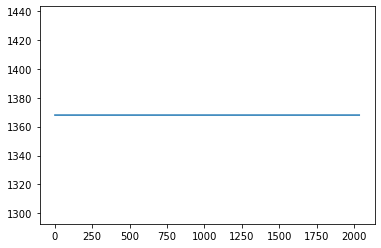

In [31]:
df['encoder_inputs_padded'].apply(len).plot()

In [32]:
padding_size_decoder = df_raw['summary_tokenized'].apply(len).max() + 2

In [33]:
df['decoder_inputs_padded'] = list(pad_sequences(df['decoder_inputs'], maxlen=padding_size_decoder, value=word_to_id['<PAD>']))

C:\Users\MARTIN~1\AppData\Local\Temp/ipykernel_10980/1196234322.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df['decoder_inputs_padded'] = list(pad_sequences(df['decoder_inputs'], maxlen=padding_size_decoder, value=word_to_id['<PAD>']))


## Models and results

In [34]:
model_no_embeddings = create_model(padding_size_encoder, padding_size_decoder, len(smaller_voc), 50)

In [35]:
df.head(5)

,encoder_inputs,decoder_inputs,decoder_outputs,decoder_outputs_room,decoder_outputs_great,decoder_outputs_location,decoder_outputs_hotel,decoder_outputs_staff,decoder_outputs_rooms,decoder_outputs_battery,...,decoder_outputs_refurbishment,decoder_outputs_regardless,decoder_outputs_efficiency,decoder_outputs_peak,decoder_outputs_<START>,decoder_outputs_<END>,decoder_outputs_<OTHER>,decoder_outputs_<PAD>,encoder_inputs_padded,decoder_inputs_padded
0,"[390, 1930, 2935, 297, 7, 2935, 180, 0, 138, 1...",[2933],good,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"[7, 227, 2, 1, 131, 7, 22, 334, 58, 2, 1, 390,...","[2936, 2936, 2936, 2936, 2936, 2936, 2936, 293..."
1,"[390, 1930, 2935, 297, 7, 2935, 180, 0, 138, 1...","[2933, 8]",service,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"[7, 227, 2, 1, 131, 7, 22, 334, 58, 2, 1, 390,...","[2936, 2936, 2936, 2936, 2936, 2936, 2936, 293..."
2,"[390, 1930, 2935, 297, 7, 2935, 180, 0, 138, 1...","[2933, 8, 7]",sometimes,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"[7, 227, 2, 1, 131, 7, 22, 334, 58, 2, 1, 390,...","[2936, 2936, 2936, 2936, 2936, 2936, 2936, 293..."
3,"[390, 1930, 2935, 297, 7, 2935, 180, 0, 138, 1...","[2933, 8, 7, 412]",slow,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"[7, 227, 2, 1, 131, 7, 22, 334, 58, 2, 1, 390,...","[2936, 2936, 2936, 2936, 2936, 2936, 2936, 293..."
4,"[390, 1930, 2935, 297, 7, 2935, 180, 0, 138, 1...","[2933, 8, 7, 412, 348]",friendly,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"[7, 227, 2, 1, 131, 7, 22, 334, 58, 2, 1, 390,...","[2936, 2936, 2936, 2936, 2936, 2936, 2936, 293..."


In [36]:
drop_columns = ['encoder_inputs', 'decoder_inputs',
                'decoder_outputs', 'encoder_inputs_padded', 'decoder_inputs_padded']
(
    X_train, X_val, Y_train, Y_val
) = train_test_split(df[['encoder_inputs_padded', 'decoder_inputs_padded']],
                     df.drop(drop_columns, axis=1),
                     test_size=1/9,
                     random_state=0)

In [37]:
X_train_list = [np.stack(X_train['encoder_inputs_padded']), np.stack(X_train['decoder_inputs_padded'])]

In [38]:
X_val_list = [np.stack(X_val['encoder_inputs_padded']), np.stack(X_val['decoder_inputs_padded'])]

In [39]:
model_no_embeddings.fit(X_train_list, Y_train.to_numpy(), batch_size=64, epochs=200, validation_data=(X_val_list, Y_val.to_numpy()), verbose=1)

Epoch 1/200
29/29 [==============================] - 9s 149ms/step - loss: 6.4675 - val_loss: 6.2237
Epoch 2/200
29/29 [==============================] - 3s 119ms/step - loss: 5.3767 - val_loss: 6.2969
Epoch 3/200
29/29 [==============================] - 3s 118ms/step - loss: 5.1888 - val_loss: 6.4264
Epoch 4/200
29/29 [==============================] - 3s 118ms/step - loss: 4.9910 - val_loss: 6.5422
Epoch 5/200
29/29 [==============================] - 3s 117ms/step - loss: 4.7162 - val_loss: 6.7030
Epoch 6/200
29/29 [==============================] - 4s 129ms/step - loss: 4.3620 - val_loss: 6.9378
Epoch 7/200
29/29 [==============================] - 4s 130ms/step - loss: 3.9874 - val_loss: 7.0346
Epoch 8/200
29/29 [==============================] - 4s 124ms/step - loss: 3.5795 - val_loss: 7.2343
Epoch 9/200
29/29 [==============================] - 4s 124ms/step - loss: 3.9234 - val_loss: 6.9980
Epoch 10/200
29/29 [==============================] - 3s 117ms/step - loss: 2.9371 - val_lo

In [40]:
def encode(sentences, padding='pre'):
    encoder_inputs = [
        [word_to_id.get(token, word_to_id['<OTHER>']) for token in sentence] for sentence in sentences
    ]
    encoder_inputs_padded = pad_sequences(
        encoder_inputs, padding=padding, maxlen=padding_size_encoder, value=word_to_id['<PAD>'])
    return encoder_inputs_padded

In [41]:
def convert(sentences):
    out_sentences = []

    for sent in sentences:
        out_sentences.append(' '.join([id_to_word[s] for s in sent if s != word_to_id['<PAD>']]))

    return out_sentences

In [42]:
df_raw['summary_tokenized_filtered']

0      [<START>, unit, generally, quite, accurate, se...
1      [<START>, garmin, seems, generally, accurate, ...
2      [<START>, accurate, even, destination, time, <...
3      [<START>, accurate, travel, destination, time,...
4      [<START>, accurate, fast, simple, operations, ...
                             ...                        
233    [<START>, voice, bit, robotic, voice, clear, l...
234    [<START>, voices, sound, robotic, tts, mode, p...
235    [<START>, 255w, garmin, gps, 750, voices, soun...
236    [<START>, voice, clear, sweet, voice, commands...
237                 [<START>, voice, clear, loud, <END>]
Name: summary_tokenized_filtered, Length: 238, dtype: object

In [43]:
x_test_encoded = encode(x_test, padding='post')
x_test_encoded

array([[  87,  298,  178, ..., 2936, 2936, 2936],
       [ 336,    6,   17, ..., 2936, 2936, 2936],
       [2935,  173,    3, ...,    3,   35,    4],
       ...,
       [ 111,   31,   11, ..., 2936, 2936, 2936],
       [ 110,  169,   12, ..., 2936, 2936, 2936],
       [ 491,  432,   79, ..., 2936, 2936, 2936]])

In [44]:
y_test_encoded = encode(y_test)
y_test_encoded

array([[2936, 2936, 2936, ..., 1370, 1965, 2934],
       [2936, 2936, 2936, ..., 2665,   98, 2934],
       [2936, 2936, 2936, ..., 1151, 1076, 2934],
       ...,
       [2936, 2936, 2936, ..., 1364,  149, 2934],
       [2936, 2936, 2936, ..., 1100,  242, 2934],
       [2936, 2936, 2936, ...,  314,  150, 2934]])

In [45]:
x_test

115    [parking, expensive, think, common, san, fran,...
15     [short, battery, life, moved, 8gb, love, ipod,...
212    [staff, friendly, helpful, staff, morning, see...
126    [eee, super, hybrid, engine, utility, lets, us...
6      [room, overly, big, clean, comfortable, beds, ...
170    [keep, mind, get, room, full, light, step, out...
9      [room, overly, big, clean, comfortable, beds, ...
222    [slowing, transmission, kicked, speed, wonder,...
112    [fact, entire, navigation, structure, complete...
221    [slowing, transmission, kicked, speed, wonder,...
183    [customer, oriented, hotelvery, low, service, ...
137    [previously, owned, toyota, 4runner, incredibl...
30     [drivers, seat, comfortable, car, compared, mo...
190    [things, 'd, like, point, must, push, micro, s...
113    [fact, entire, navigation, structure, complete...
55     [uninstall, anti, virus, selected, programs, l...
24     [6ghz, 533fsb, cpu, glossy, display, 3, cell, ...
204    [another, feature, 255w,

In [46]:
def decode(model, input_sent, word_to_id, padding_size):
    generated_sent = [word_to_id['<START>']]

    for i in range(padding_size):
        output_sent = pad_sequences([generated_sent], padding_size)
        predictions = model.predict([np.expand_dims(input_sent, axis=0), output_sent])
        next_word = np.argmax(predictions)
        generated_sent.append(next_word)

    return generated_sent

In [47]:
output_rephrases = []
for sentence in tqdm.tqdm(x_test_encoded):
    output_rephrases.append(decode(model_no_embeddings, sentence, word_to_id, padding_size_decoder))

100%|██████████| 48/48 [03:50<00:00,  4.79s/it]


In [48]:
def get_results(output_rephrases):
    input_sentences = x_test
    gt_rephrases = y_test.apply(lambda x: ' '.join(x))
    pred_rephrases = convert(output_rephrases)
    predictions = []
    for input_sent, gt_rephrase, pred_rephrase in zip(input_sentences, gt_rephrases, pred_rephrases):
        predictions.append({'gt': gt_rephrase, 'predicted': pred_rephrase})
    return score_predictions(predictions)

In [49]:
get_results(output_rephrases)

Calculating ROUGE...
Calculating BLEU...
{'testlen': 3456, 'reflen': 543, 'guess': [3456, 3408, 3360, 3312], 'correct': [49, 0, 0, 0]}
ratio: 6.364640883966179


{'ROUGE': (0.028329206249605124,
  array([0.0256734 , 0.02921456, 0.0297271 , 0.02732975, 0.02732975,
         0.0297271 , 0.02732975, 0.02921456, 0.03080808, 0.0287194 ,
         0.02824074, 0.02824074, 0.02455717, 0.0249183 , 0.02647569,
         0.02921456, 0.02647569, 0.02732975, 0.02824074, 0.0297271 ,
         0.02689594, 0.02777778, 0.03025794, 0.02824074, 0.02777778,
         0.02777778, 0.02647569, 0.02353395, 0.0249183 , 0.0297271 ,
         0.0287194 , 0.05648148, 0.02689594, 0.02824074, 0.02777778,
         0.02689594, 0.02777778, 0.02455717, 0.02921456, 0.02647569,
         0.0297271 , 0.02777778, 0.0249183 , 0.0297271 , 0.02921456,
         0.02824074, 0.02921456, 0.02606838])),
 'BLEU-1': (0.014178240740736639,
  [0.013888888888696002,
   0.013888888888696002,
   0.013888888888696002,
   0.013888888888696002,
   0.013888888888696002,
   0.013888888888696002,
   0.013888888888696002,
   0.013888888888696002,
   0.013888888888696002,
   0.013888888888696002,
   0.013888888

This function is edited in word_embeddings.py by me to accept path argument

In [50]:
glove_weights = load_embedding_weights(
    vocabulary=smaller_voc,
    embedding_size=50,
    embedding_type='glove',
    path='data'
)

In [51]:
model_glove = create_model(padding_size_encoder, padding_size_decoder, len(smaller_voc), 50, glove_weights)

In [52]:
model_glove.fit(X_train_list, Y_train.to_numpy(), batch_size=64, epochs=200, validation_data=(X_val_list, Y_val.to_numpy()), verbose=1)

Epoch 1/200
29/29 [==============================] - 9s 173ms/step - loss: 6.3361 - val_loss: 6.1971
Epoch 2/200
29/29 [==============================] - 4s 135ms/step - loss: 5.1903 - val_loss: 6.1989
Epoch 3/200
29/29 [==============================] - 4s 133ms/step - loss: 4.6427 - val_loss: 6.1637
Epoch 4/200
29/29 [==============================] - 4s 139ms/step - loss: 3.8989 - val_loss: 6.1327
Epoch 5/200
29/29 [==============================] - 4s 139ms/step - loss: 3.0611 - val_loss: 6.2775
Epoch 6/200
29/29 [==============================] - 4s 141ms/step - loss: 2.3136 - val_loss: 6.4727
Epoch 7/200
29/29 [==============================] - 4s 134ms/step - loss: 1.7603 - val_loss: 6.6220
Epoch 8/200
29/29 [==============================] - 4s 134ms/step - loss: 1.3731 - val_loss: 6.7986
Epoch 9/200
29/29 [==============================] - 4s 134ms/step - loss: 1.1517 - val_loss: 6.9304
Epoch 10/200
29/29 [==============================] - 4s 137ms/step - loss: 0.9718 - val_lo

The model starts overfitting the last few epochs seen by the training.

In [53]:
output_rephrases_glove = []
for sentence in tqdm.tqdm(x_test_encoded):
    output_rephrases_glove.append(decode(model_glove, sentence, word_to_id, padding_size_decoder))

100%|██████████| 48/48 [03:27<00:00,  4.31s/it]


In [54]:
get_results(output_rephrases_glove)

Calculating ROUGE...
Calculating BLEU...
{'testlen': 3456, 'reflen': 543, 'guess': [3456, 3408, 3360, 3312], 'correct': [49, 0, 0, 0]}
ratio: 6.364640883966179


{'ROUGE': (0.028329206249605124,
  array([0.0256734 , 0.02921456, 0.0297271 , 0.02732975, 0.02732975,
         0.0297271 , 0.02732975, 0.02921456, 0.03080808, 0.0287194 ,
         0.02824074, 0.02824074, 0.02455717, 0.0249183 , 0.02647569,
         0.02921456, 0.02647569, 0.02732975, 0.02824074, 0.0297271 ,
         0.02689594, 0.02777778, 0.03025794, 0.02824074, 0.02777778,
         0.02777778, 0.02647569, 0.02353395, 0.0249183 , 0.0297271 ,
         0.0287194 , 0.05648148, 0.02689594, 0.02824074, 0.02777778,
         0.02689594, 0.02777778, 0.02455717, 0.02921456, 0.02647569,
         0.0297271 , 0.02777778, 0.0249183 , 0.0297271 , 0.02921456,
         0.02824074, 0.02921456, 0.02606838])),
 'BLEU-1': (0.014178240740736639,
  [0.013888888888696002,
   0.013888888888696002,
   0.013888888888696002,
   0.013888888888696002,
   0.013888888888696002,
   0.013888888888696002,
   0.013888888888696002,
   0.013888888888696002,
   0.013888888888696002,
   0.013888888888696002,
   0.013888888

In [55]:
convert(output_rephrases_glove)

['<START> room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room',
 '<START> room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room',
 '<START> room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room room r

## Conclusion

The results are bad. I had slightly more varied answers with 40 epochs.
The validation loss constantly increases for any epoch count.